# Power analysis

In [12]:
import json
import os
import numpy as np
import re
import pandas as pd

seed = 37
np.random.seed(seed)

In [13]:
# Data INPUT to be written to a JSON file
name_architectures = [
    'Clements_Arct', 'ClementsBell_Arct',
    'Fldzhyan_Arct', 'FldzhyanBell_Arct',
    'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct',
    'NEUROPULSBell_Arct', 'NEUROPULSBell2_Arct',
    'NEUROPULSBellCrossingSide_Arct', 'NEUROPULSBellCrossingSide2_Arct',]       # REMEMBETO TO INVERT THE NEUROPULSBellCrossingSide_Arct with version 2

arct = 'Clements_Arct'

n_inputs = 8
if n_inputs == 4:
    n_epochs = 20000
elif n_inputs == 6:
    n_epochs = 21000
elif n_inputs == 8:
    n_epochs = 22000
elif n_inputs == 10:
    n_epochs = 23000
elif n_inputs == 12:
    n_epochs = 24000
elif n_inputs == 14:
    n_epochs = 25000
elif n_inputs == 16:
    n_epochs = 26000

name_file = "powers_"+arct+"_N"+str(n_inputs)

data = {
    "name_file": name_file,
    "arct": arct,
    "n_inputs": n_inputs,
    "n_epochs": n_epochs,
    "date": "20240801",
    "train_type": "1-Fidelity",
    "seed": 37,
    "n_matrices": 1000,
    "n_repetitions": 5,
    "lr": 0.001,
    "n_bachup": 500,

    "data_out_type": "losses",
    "rep_type": "all repetitions take considerations",
    "num_vectors": 1000,
    "simulations": []
    }

folder_relative_path = "organized_data/"

if True:
    # Write JSON data to a file
    with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)

In [14]:
def append_gaussian_output_simulation(data, pc_iloss_mu, pc_iloss_sigma, imbalance_mu, average=None, std_dev=None):
    dictionary = {
        "pc_iloss_mu": pc_iloss_mu,
        "pc_iloss_sigma": pc_iloss_sigma,
        "i_loss_MMI_mu": -0.25,
        "i_loss_MMI_sigma": 0.1,
        "imbalance_mu": imbalance_mu,
        "imbalance_sigma": 0.15,
        "i_loss_Crossing_mu": -0.25,
        "i_loss_Crossing_sigma": 0.05,
        "cross_talk_mu": -35.0,
        "cross_talk_sigma": 1.0,

        "average": average,
        "std_dev": std_dev
        }
    
    data["simulations"].append(dictionary)

In [15]:
# Read
with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'r') as file:
    data = json.load(file)

# Derive the LOSSES average and std deviations

In [23]:
# Extract data matrix of the predictions matricies
def extract_prediction_matrices_1sim(directory, arct):
    prediction_matrices = []
    # Loop through each file in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)       # Construct the full file path
        if os.path.isfile(file_path):                       # Check if it is a file
            result_sim = np.load(file_path, allow_pickle=True)
            predic_m = [array for label, array in result_sim if arct in label and "prediction" in label]
        if predic_m:    # If there are elements
            prediction_matrices.extend(predic_m)
        # else:
        #     return None
    return prediction_matrices

# Create the inputs (electri fiels so I need to make the ) uniform distribution in power signle input [0, 1]
def define_inputs_eletrical_fields(num_vectors, n_inputs):
    input_vectors = np.sqrt(np.random.uniform(0, 1, (num_vectors, n_inputs))/n_inputs)
    return input_vectors

def extract_values(simulation_folder):
    # Patterns to match each value, ensuring correct order
    patterns = {
        'pcilossmu': r"pcilossmu(-?\d+\.\d+)",
        'pcilosssigma': r"pcilosssigma(-?\d+\.\d+)",
        'imbalancemu': r"imbalancemu(-?\d+\.\d+)",
    }
    values = {}
    last_end = 0  # Track the end position of the last match
    for key, pattern in patterns.items():
        match = re.search(pattern, simulation_folder[last_end:])
        if match:
            values[key] = float(match.group(1))
            last_end += match.end()
    return values

# Derive the losses my making the moltiplipication matrix for 
def models_losses_mean_devstd(preditions, input_vectors, simulation_folder):
    preditions = np.array(preditions)
    input_vectors = np.array(input_vectors)
    power_in_tots = np.sum(np.abs(input_vectors)**2, axis=1)
    
    losses = []
    for matrix in preditions:
        output_vectors = []
        for input_v in input_vectors:
            output_vectors.append(np.dot(matrix, input_v))
        power_out_tots = np.sum(np.abs(output_vectors)**2, axis=1)
        losses.extend(power_out_tots/power_in_tots)
    losses_dB = 10 * np.log10(losses)

    loss_average = np.mean(losses)
    loss_std_dev = np.std(losses)
    loss_average_dB = np.mean(losses_dB)
    loss_std_dev_dB = np.std(losses_dB)
    
    # Extract and convert to float
    extract_hyp = extract_values(simulation_folder)
    ave_std_dev_pd = pd.DataFrame([{'simulation':simulation_folder,
                                    'pcilossmu': extract_hyp['pcilossmu'],
                                    'pcilosssigma': extract_hyp['pcilosssigma'],
                                    'imbalancemu': extract_hyp['imbalancemu'],
                                    'loss_average': loss_average, 'loss_std_dev': loss_std_dev,
                                    'loss_average_dB': loss_average_dB, 'loss_std_dev_dB': loss_std_dev_dB,}])

    return ave_std_dev_pd
    

# =================================================================================================================
# MAIN
# =================================================================================================================
directory_run = 'outdata/20240723_run_3_gaus'

data_df = pd.DataFrame()
input_vectors = define_inputs_eletrical_fields(data["num_vectors"], data["n_inputs"])
for filename in os.listdir(directory_run):
    directory_path = os.path.join(directory_run, filename)       # Construct the full file path
    if "n"+str(data["n_inputs"]) in directory_path:             # I don't like it but ok
        if not os.path.isfile(directory_path):
            predictions = extract_prediction_matrices_1sim(directory_path, data["arct"])
            if predictions is not None:   # No data in that simulation
                simulation_folder = os.path.basename(directory_path)
                ave_std_dev_pd = models_losses_mean_devstd(predictions, input_vectors, simulation_folder)
                data_df = pd.concat([data_df, ave_std_dev_pd], ignore_index=True)

KeyboardInterrupt: 

## Write inside the JSON file

In [6]:
# Read
with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'r') as file:
    data = json.load(file)

for index, row in data_df.iterrows():
    # !!!!!!!!!!!! I'm APPENDING ELEMENTS !!!!!!!!!!!!!!!!!!!!!!!!!!!
    append_gaussian_output_simulation(
        data=data,
        pc_iloss_mu=row['pcilossmu'],
        pc_iloss_sigma=row['pcilosssigma'],
        imbalance_mu=row['imbalancemu'],
        average=row['average'],
        std_dev=row['std_dev'],)

if True:
    # Write JSON data to a file
    with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)

## Sort by imb

In [7]:
# Sort the dictionary by PC_i_loss and imbalances

# Read
with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'r') as file:
    data = json.load(file) 

# Sort by CROSS TALK
simulations = data["simulations"]
sorted_simulations = sorted(simulations, key=lambda x: x['cross_talk_const'])
data["simulations"] = sorted_simulations

# Sort by IMBALANCES
simulations = data["simulations"]
sorted_simulations = sorted(simulations, key=lambda x: x['imbalance_const'])
data["simulations"] = sorted_simulations

# Sort by INSERSION LOSS MMI
simulations = data["simulations"]
sorted_simulations = sorted(simulations, key=lambda x: x['i_loss_const'])
data["simulations"] = sorted_simulations

# Sort by PC_LOSSES
simulations = data["simulations"]
sorted_simulations = sorted(simulations, key=lambda x: x['PC_i_loss_const'])
data["simulations"] = sorted_simulations


if True:
    # Write JSON data to a file
    with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'w') as json_file:
        json.dump(data, json_file, indent=4)

# All code combine to speed up a little

In [9]:
# Data INPUT to be written to a JSON file
name_architectures = [
    'Clements_Arct', 'ClementsBell_Arct',
    'Fldzhyan_Arct', 'FldzhyanBell_Arct',
    'NEUROPULS_Arct', 'NEUROPULSCrossingSide_Arct',
    'NEUROPULSBell_Arct', 'NEUROPULSBell2_Arct',
    'NEUROPULSBellCrossingSide_Arct', 'NEUROPULSBellCrossingSide2_Arct',]

for arct in name_architectures:

    n_inputs = 8
    if n_inputs == 4:
        n_epochs = 20000
    elif n_inputs == 6:
        n_epochs = 21000
    elif n_inputs == 8:
        n_epochs = 22000
    elif n_inputs == 10:
        n_epochs = 23000
    elif n_inputs == 12:
        n_epochs = 24000
    elif n_inputs == 14:
        n_epochs = 25000
    elif n_inputs == 16:
        n_epochs = 26000

    name_file = "powers_"+arct+"_N"+str(n_inputs)

    data = {
        "name_file": name_file,
        "arct": arct,
        "n_inputs": n_inputs,
        "n_epochs": n_epochs,
        "date": "20240801",
        "train_type": "1-Fidelity",
        "seed": 37,
        "n_matrices": 1000,
        "n_repetitions": 5,
        "lr": 0.001,
        "n_bachup": 500,

        "data_out_type": "losses",
        "rep_type": "all repetitions take considerations",
        "num_vectors": 1000,
        "simulations": []
        }

    folder_relative_path = "organized_data/"

    if True:
        # Write JSON data to a file
        with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'w') as json_file:
            json.dump(data, json_file, indent=4)
    
    # =============================================================================================================
    def append_output_simulation(data, PC_i_loss_const, i_loss_const, imbalance_const, cross_talk_const,
                                loss_average=None, loss_std_dev=None, loss_average_dB=None, loss_std_dev_dB=None):
        dictionary = {
            "PC_i_loss_const": PC_i_loss_const,
            "i_loss_const": i_loss_const,
            "imbalance_const": imbalance_const,
            "cross_talk_const": cross_talk_const,
            "loss_average": loss_average,
            "loss_std_dev": loss_std_dev,
            "loss_average_dB": loss_average_dB,
            "loss_std_dev_dB": loss_std_dev_dB
            }
        
        data["simulations"].append(dictionary)

    # =============================================================================================================
    # Read
    with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'r') as file:
        data = json.load(file)

    # =============================================================================================================
    # Extract data matrix of the predictions matricies
    def extract_prediction_matrices_1sim(directory, arct):
        prediction_matrices = []
        # Loop through each file in the directory
        for filename in os.listdir(directory):
            file_path = os.path.join(directory, filename)       # Construct the full file path
            if os.path.isfile(file_path):                       # Check if it is a file
                result_sim = np.load(file_path, allow_pickle=True)
                predic_m = [array for label, array in result_sim if arct in label and "prediction" in label]
            if predic_m:    # If there are elements
                prediction_matrices.extend(predic_m)
            else:
                return None
        return prediction_matrices

    # Create the inputs (electri fiels so I need to make the ) uniform distribution in power signle input [0, 1]
    def define_inputs_eletrical_fields(num_vectors, n_inputs):
        input_vectors = np.sqrt(np.random.uniform(0, 1, (num_vectors, n_inputs))/n_inputs)
        return input_vectors

    def extract_values(simulation_folder):
        # Patterns to match each value, ensuring correct order
        patterns = {
            'pciloss': r"pciloss(-?\d+\.\d+)",
            'iloss': r"iloss(-?\d+\.\d+)",
            'imb': r"imb(-?\d+\.\d+)",
            'crosstalk': r"crosstalk(-?\d+\.\d+)"
        }
        values = {}
        last_end = 0  # Track the end position of the last match
        for key, pattern in patterns.items():
            match = re.search(pattern, simulation_folder[last_end:])
            if match:
                values[key] = float(match.group(1))
                last_end += match.end()
        return values

    # Derive the losses my making the moltiplipication matrix for 
    def models_losses_mean_devstd(preditions, input_vectors, simulation_folder):
        preditions = np.array(preditions)
        input_vectors = np.array(input_vectors)
        power_in_tots = np.sum(np.abs(input_vectors)**2, axis=1)
        
        losses = []
        for matrix in preditions:
            output_vectors = []
            for input_v in input_vectors:
                output_vectors.append(np.dot(matrix, input_v))
            power_out_tots = np.sum(np.abs(output_vectors)**2, axis=1)
            losses.extend(power_out_tots/power_in_tots)
        losses_dB = 10 * np.log10(losses)

        loss_average = np.mean(losses)
        loss_std_dev = np.std(losses)
        loss_average_dB = np.mean(losses_dB)
        loss_std_dev_dB = np.std(losses_dB)
        
        # Extract and convert to float
        extract_hyp = extract_values(simulation_folder)
        ave_std_dev_pd = pd.DataFrame([{'simulation':simulation_folder,
                                        'pciloss': extract_hyp['pciloss'],
                                        'iloss': extract_hyp['iloss'],
                                        'imb': extract_hyp['imb'],
                                        'crosstalk': extract_hyp['crosstalk'],
                                        'loss_average': loss_average, 'loss_std_dev': loss_std_dev,
                                        'loss_average_dB': loss_average_dB, 'loss_std_dev_dB': loss_std_dev_dB,}])

        return ave_std_dev_pd
        

    # =================================================================================================================
    # MAIN
    # =================================================================================================================
    directory_run = 'outdata/20240723_run_2_PCiloss'

    data_df = pd.DataFrame()
    input_vectors = define_inputs_eletrical_fields(data["num_vectors"], data["n_inputs"])
    for filename in os.listdir(directory_run):
        directory_path = os.path.join(directory_run, filename)       # Construct the full file path
        if "n"+str(data["n_inputs"]) in directory_path:             # I don't like it but ok
            if not os.path.isfile(directory_path):
                predictions = extract_prediction_matrices_1sim(directory_path, data["arct"])
                if predictions is not None:   # No data in that simulation
                    simulation_folder = os.path.basename(directory_path)
                    ave_std_dev_pd = models_losses_mean_devstd(predictions, input_vectors, simulation_folder)
                    data_df = pd.concat([data_df, ave_std_dev_pd], ignore_index=True)
    
    # =============================================================================================================
    # Read
    with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'r') as file:
        data = json.load(file)

    for index, row in data_df.iterrows():
        # !!!!!!!!!!!! I'm APPENDING ELEMENTS !!!!!!!!!!!!!!!!!!!!!!!!!!!
        append_output_simulation(
            data=data,
            PC_i_loss_const=row['pciloss'],
            i_loss_const=row['iloss'],
            imbalance_const=row['imb'],
            cross_talk_const=row['crosstalk'],
            loss_average=row['loss_average'],
            loss_std_dev=row['loss_std_dev'],
            loss_average_dB=row['loss_average_dB'],
            loss_std_dev_dB=row['loss_std_dev_dB'],)

    if True:
        # Write JSON data to a file
        with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'w') as json_file:
            json.dump(data, json_file, indent=4)

    # =============================================================================================================
    # Sort the dictionary by PC_i_loss and imbalances

    # Read
    with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'r') as file:
        data = json.load(file) 

    # Sort by CROSS TALK
    simulations = data["simulations"]
    sorted_simulations = sorted(simulations, key=lambda x: x['cross_talk_const'])
    data["simulations"] = sorted_simulations

    # Sort by IMBALANCES
    simulations = data["simulations"]
    sorted_simulations = sorted(simulations, key=lambda x: x['imbalance_const'])
    data["simulations"] = sorted_simulations

    # Sort by INSERSION LOSS MMI
    simulations = data["simulations"]
    sorted_simulations = sorted(simulations, key=lambda x: x['i_loss_const'])
    data["simulations"] = sorted_simulations

    # Sort by PC_LOSSES
    simulations = data["simulations"]
    sorted_simulations = sorted(simulations, key=lambda x: x['PC_i_loss_const'])
    data["simulations"] = sorted_simulations


    if True:
        # Write JSON data to a file
        with open(folder_relative_path+data["date"]+"_"+data["name_file"]+'.json', 'w') as json_file:
            json.dump(data, json_file, indent=4)

Vector 1: [0.21637355 0.34473075 0.30248842 0.27355495 0.13965074 0.13963995
 0.08520828 0.32904714], Sum: 1.830693779699244
Vector 2: [0.27411563 0.29750474 0.05072536 0.34819353 0.32257608 0.16291835
 0.15075849 0.1514119 ], Sum: 1.7582040723389565
Vector 3: [0.19501354 0.25611434 0.23236421 0.19079739 0.27655309 0.13204822
 0.19109705 0.2139982 ], Sum: 1.6879860345357598
Vector 4: [0.23876505 0.31328421 0.15798488 0.25353364 0.27212464 0.07619909
 0.27557777 0.14599834], Sum: 1.7334676174379515
Vector 5: [0.09017455 0.34439903 0.34742482 0.31788311 0.19513257 0.11049441
 0.29245363 0.23456142], Sum: 1.9325235417327842


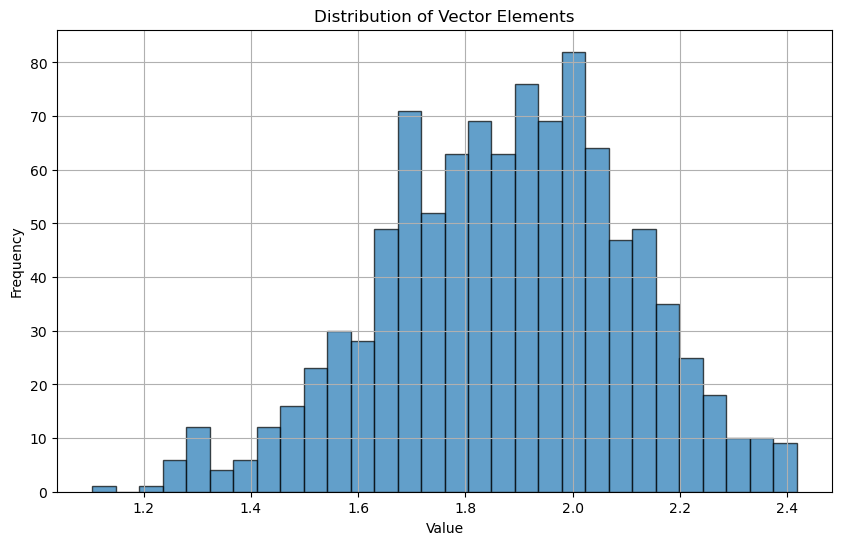

In [104]:
# Create 1000 random inputs uniform distribution
import matplotlib.pyplot as plt
np.random.seed(seed)

def generate_inputs(num_inputs, n, seed):
    np.random.seed(seed)
    vectors = np.sqrt(np.random.uniform(0, 1, (num_inputs, n))/n)
    return vectors

# Parameters
num_inputs = 1000
n = 8  # Example length, you can change this

# Generate vectors
inputs = generate_inputs(num_inputs, n, seed)

for i, vector in enumerate(inputs[:5]):
    print(f"Vector {i + 1}: {vector}, Sum: {np.sum(vector)}")


# Flatten the array to get a single array of all elements
all_elements = np.sum(inputs, axis=1).flatten()

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.hist(all_elements, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Vector Elements')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



In [102]:
# mMUltiiply together the matrix and vector

def multiply_matrices_vectors(matrices, inputs):
    matrices = np.array(matrices)
    inputs = np.array(inputs)
    
    losses = []
    for matrix in matrices:
        results = []
        for in_v in inputs:
            result_vector = np.dot(matrix, in_v)
            results.append(result_vector)
        out_square_modulus = np.abs(results)**2
        out_sums = np.sum(out_square_modulus, axis=1)
        in_square_modulus = np.abs(inputs)**2
        in_sums = np.sum(in_square_modulus, axis=1)
        losses.extend(out_sums/in_sums)
    losses_dB = 10 * np.log10(losses)
    return np.array(losses), np.array(losses_dB)


losses, losses_dB = multiply_matrices_vectors(predictions, inputs)


print(losses)
print(len(losses))
average = np.mean(losses)
std_dev = np.std(losses)
print(average)
print(std_dev)

average_db = np.mean(losses_dB)
std_dev_db = np.std(losses_dB)

print(average_db)
print(std_dev_db)


[0.19991635 0.19491178 0.19791767 ... 0.19986337 0.19811969 0.19841521]
5000000
0.20158284999611878
0.010544659668227166
-6.961373096741088
0.2263070148261611


In [103]:
print(10 * np.log10(average))
print(10 * np.log10(std_dev))

-6.9554641899671745
-19.769674326714025
